### Author
Sheida Abedpour  
Connect with me on [GitHub](https://github.com/SheidaAbedpour), [LinkedIn](https://www.linkedin.com/in/sheida-abedpour-sh02), or via [email](mailto:sheida.abedpour2002@gmail.com).

### About the Project
This project aims to predict credit limits using machine learning methods, including feature encoding, scaling, selection, and handling multicollinearity. Regression models will be used for this project.
ct.


In [1]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [2]:
# Class for preprocessing data before applying machine learning algorithms
class Preprocessing:

    # Method for imputing missing values with mean
    @classmethod
    def mean_imputation(self, data, inplace = False):
        data.fillna(data.mean(), inplace = inplace)

    
    # Method for imputing missing values with median
    @classmethod
    def median_imputation(self, data, inplace = False):
        data.fillna(data.median(), inplace = inplace)
        

    # Method for imputing missing values with mode
    @classmethod
    def mode_imputation(self, data, inplace = False):
        data.fillna(data.mode(), inplace = inplace)
        

    # Method for imputing missing values using a decision tree-based approach
    @classmethod
    def tree_imputation(self, data):
        missing_cols = [col for col in data.columns if data[col].isnull().sum() > 0]
        non_missing_cols = [col for col in data.columns if data[col].isnull().sum() == 0]
    
        for col in missing_cols:
            model = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 40, max_samples = 1.0,
                                     max_features = 1.0, bootstrap = False, n_jobs = -1)

            col_missing = data[data[col].isnull()]
            temp = data.drop(data[data[col].isnull()].index, axis = 0)
            
            X = temp.loc[:, non_missing_cols]
            y = temp[col]
    
            model.fit(X, y)
    
            y_pred = model.predict(col_missing[non_missing_cols])
    
            data.loc[col_missing.index, col] = y_pred
        
        return data
        

    # Method to find outliers in a specific feature using IQR
    @classmethod
    def find_outliers(self, data, feature):
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    

    # Method for encoding categorical features
    @classmethod
    def encoding(self, df):
        education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3,
                             'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
        income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3,
                          '$80K - $120K': 4, '$120K +': 5}
        card_mapping = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
        gender_mapping = {'F': 0, 'M': 1}
        marital_mapping = {'Divorced': 0, 'Unknown': 1, 'Single': 2, 'Married': 3}
        
        df['Education_Level'] = df['Education_Level'].map(education_mapping)
        df['Income_Category'] = df['Income_Category'].map(income_mapping)
        df['Card_Category'] = df['Card_Category'].map(card_mapping)
        df['Gender'] = df['Gender'].map(gender_mapping)
        df['Marital_Status'] = df['Marital_Status'].map(marital_mapping)
           
        # # One-hot Encoding for nominal Categorical Features
        # columns_to_encode = ['Gender', 'Marital_Status']
        # encoder = OneHotEncoder(drop='first', dtype=np.float64, handle_unknown='ignore', sparse_output=False)
        # encoded = encoder.fit_transform(df[columns_to_encode])
        # encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns_to_encode))
        # df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

        # # put nan for missied values
        # for column in columns_to_encode:
        #     nan_col = column + '_nan'
        #     encoded_columns = [col for col in df.columns if col.startswith(column + '_') and col != nan_col]
        #     for encoded_col in encoded_columns:
        #         df.loc[df[nan_col] == 1, encoded_col] = np.nan
        
        # # Drop the NaN indicator columns
        # df = df.drop(columns=[col + '_nan' for col in columns_to_encode])
        
        return df
        

    # Method for splitting data into train and test sets
    @classmethod
    def split(self, data, size=0.2, seed=42):
        train_df, test_df = train_test_split(df, test_size=size, shuffle=True, random_state=seed)
        return train_df, test_df
        

    # Method to calculate lower and upper whiskers for outliers
    @classmethod
    def wisker(self, column):
        q1, q3 = np.percentile(column, [25, 75])
        iqr = q3 - q1
        lw = q1 - 1.5 * iqr
        uw = q3 + 1.5 * iqr
        return lw, uw
        

    # Method to treat outliers by capping values
    @classmethod
    def treat_outlier(self, data, data_columns):
        def cap(x):
            q5 = np.percentile(x, 5)
            q25 = np.percentile(x, 25)
            q75 = np.percentile(x, 75)
            up_trend = np.percentile(x, 95)
            IQR = q75 - q25
            LTV = q25 - 1.5 * IQR
            UTV = q75 + 1.5 * IQR
            
            # Cap the values
            capped = np.where(x > UTV, up_trend, np.where(x < LTV, q5, x))
            return capped
        
        for col in data_columns:
            data[col] = cap(data[col])
        return data
        

    # Method for scaling features using Min-Max scaling
    @classmethod
    def scale(self, x_train, x_test):
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        return x_train, x_test



# Loading Data
____________________________________________________________________________________________________________________

Let's load a CSV file named "CreditPrediction.csv" into a pandas DataFrame (df) and then drop the column labeled "Unnamed: 19" (an empty column) from the DataFrame.

In the first step, we remove irrelevant columns that are not influential in prediction. In this dataset, the 'CLIENTNUM' column represents a unique identifier for each customer and should not be considered a predictive feature.

In the second step, we eliminate duplicate data entries from the dataset to prevent any skewing of statistical analyses.

Finally, it's essential to inspect the values present in categorical features to ensure that incorrect characters are not mistakenly entered.


In [3]:
df = pd.read_csv('CreditPrediction.csv').drop('Unnamed: 19', axis='columns')
print(df.shape)
df.head()

(10167, 19)


CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
0  768805383          45.0      M                3     High School   
1  818770008          49.0      F                5        Graduate   
2  713982108          51.0      M                3        Graduate   
3  769911858          40.0      F                4     High School   
4  709106358          40.0      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue            39.0   
1            NaN  Less than $40K          Blue            44.0   
2        Married    $80K - $120K          Blue            36.0   
3            NaN  Less than $40K          Blue            34.0   
4        Married     $60K - $80K           NaN            21.0   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                       5.0                       1                      3   
1                       6.0                       1                      2   
2                       4.0                       1                      0   
3                       3.0                       4                      1   
4                       5.0                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
0       12691.0                  777                 1.335             1144   
1        8256.0                  864                 1.541             1291   
2        3418.0                    0                 2.594             1887   
3        3313.0                 2517                 1.405             1171   
4        4716.0                    0                 2.175              816   

   Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0              42                1.625                  0.061  
1              33                3.714                  0.105  
2              20                2.333                  0.000  
3              20                2.333                  0.760  
4              28                2.500                  0.000

In [4]:
# Drop Unwanted Columns
df = df.drop('CLIENTNUM', axis='columns') # Identifier, not typically used as a feature for analysis

# Remove Duplicated Rows
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

(10132, 18)


In [5]:
df_copy = df.copy()

In [6]:
# Check Garbage Values in Categorical Features
for col in df.select_dtypes(include="object").columns:
    print(df[col].value_counts())
    print("\n")

Gender
F    5247
M    4686
Name: count, dtype: int64


Education_Level
Graduate         3129
High School      2014
Unknown          1519
Uneducated       1488
College          1015
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64


Marital_Status
Married     3793
Single      3184
Unknown      621
Divorced     595
Name: count, dtype: int64


Income_Category
Less than $40K    3562
$40K - $60K       1791
$80K - $120K      1535
$60K - $80K       1402
Unknown           1115
$120K +            727
Name: count, dtype: int64


Card_Category
Blue        7644
Silver       461
Gold          96
Platinum      16
Name: count, dtype: int64




# Encoding Categorical Features
____________________________________________________________________________________________________________________

The next step in preprocessing is to convert categorical features into numerical ones because regression models cannot process non-numeric data. This transformation is necessary before splitting the data into training and testing sets because categorical features with low occurrence in the test set may pose encoding issues.

We perform this step using the `Preprocessing.encoding()` method, ensuring that all categorical features are encoded consistently across the entire dataset. 

Let's apply this encoding transformation to our DataFrame (`df`), and then inspect the updated DataFrame to confirm that categorical features have been properly encodd.



In [7]:
df = Preprocessing.encoding(df)
df.head()

Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
0          45.0     1.0                3                2             3.0   
1          49.0     0.0                5                4             NaN   
2          51.0     1.0                3                4             3.0   
3          40.0     0.0                4                2             NaN   
4          40.0     1.0                3                1             3.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0                3            0.0            39.0                       5.0   
1                1            0.0            44.0                       6.0   
2                4            0.0            36.0                       4.0   
3                1            0.0            34.0                       3.0   
4                3            NaN            21.0                       5.0   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                  777                 1.335             1144              42   
1                  864                 1.541             1291              33   
2                    0                 2.594             1887              20   
3                 2517                 1.405             1171              20   
4                    0                 2.175              816              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0                1.625                  0.061  
1                3.714                  0.105  
2                2.333                  0.000  
3                2.333                  0.760  
4                2.500                  0.000

# Split Train and Test
____________________________________________________________________________________________________________________


After encoding categorical features, it's crucial to separate the data into training and testing sets to ensure that future preprocessing steps are applied separately to each set. When splitting the data into training and testing sets, it's essential to consider minimizing bias and ensuring that their distributions are similar. We want to avoid the model learning from the testing data, as it may lead to overfitting.

Let's proceed with splitting the data into training and testing sets. We'll use the `Preprocessing.split()` method with a test size of 20% and a random seed of 42.

Additionally, let's visualize the distribution of the 'Credit_Limit'(lables) feature in both the training and testing sets to ensure that their distributions are comparable.

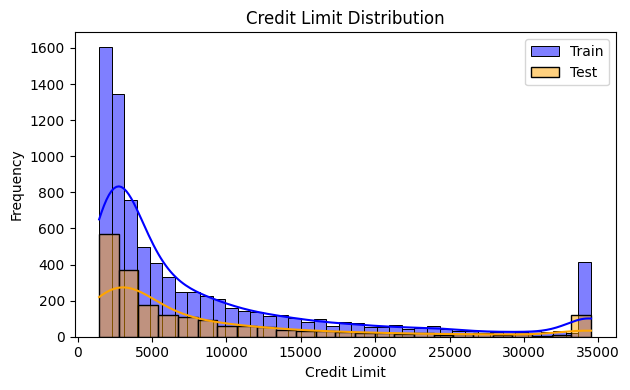

(8105, 18)


In [8]:
# Split the data
train_df, test_df = Preprocessing.split(df, 0.2, 42)

# Plot the distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Credit_Limit'], kde=True, color='blue', label='Train')
sns.histplot(test_df['Credit_Limit'], kde=True, color='orange', label='Test')
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(train_df.shape)

# Data Analysis
____________________________________________________________________________________________________________________

- **Checking Missing Values**: This step identifies missing values in the training set, summarizes the findings, and calculates the percentage of missing values in both the training set and the entire dataset.

- **Visualizing Correlation Matrix**: It visualizes the correlation matrix of numerical features in the training set using a heatmap to identify correlations between features.

- **Visualizing Numeric Features**: Using scatter plots, box plots, and histograms, this step helps understand the relationship of numeric features with the target variable ('Credit_Limit').

- **Visualizing Categorical Features**: Box plots are used to visualize the relationship between categorical features and the target variable, providing insights into their impact.

- **Plotting Bar Plots for Categorical Features**: For each categorical feature, including NaN values, bar plots visualize category distributions and identify patterns.

- **Visualizing Missing Data Patterns**: Using a dendrogram, this step identifies systematic patterns or correlations in missing values across differe
nt columns.

These analyses aid in imputation strategies and outlier detection, ultimately enhancing the quality and reliability of the dataset for subsequent modeling tasks.
columns.



In [9]:
nan_counts = train_df.isna().sum().sort_values(ascending=False)
summary = pd.concat([train_df.info(), nan_counts], axis=0)
summary

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    7947 non-null   float64
 2   Dependent_count           8105 non-null   int64  
 3   Education_Level           8105 non-null   int64  
 4   Marital_Status            6576 non-null   float64
 5   Income_Category           8105 non-null   int64  
 6   Card_Category             6586 non-null   float64
 7   Months_on_book            7921 non-null   float64
 8   Total_Relationship_Count  8087 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

Marital_Status              1529
Card_Category               1519
Months_on_book               184
Gender                       158
Total_Relationship_Count      18
Customer_Age                   0
Total_Revolving_Bal            0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Total_Trans_Amt                0
Total_Amt_Chng_Q4_Q1           0
Months_Inactive_12_mon         0
Credit_Limit                   0
Contacts_Count_12_mon          0
Income_Category                0
Education_Level                0
Dependent_count                0
Avg_Utilization_Ratio          0
dtype: int64

In [10]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(7)

Total     %
Marital_Status             1529  18.9
Card_Category              1519  18.7
Months_on_book              184   2.3
Gender                      158   1.9
Total_Relationship_Count     18   0.2
Customer_Age                  0   0.0
Total_Revolving_Bal           0   0.0

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(7)

Total     %
Marital_Status             1939  23.9
Card_Category              1915  23.6
Months_on_book              221   2.7
Gender                      199   2.5
Total_Relationship_Count     20   0.2
Customer_Age                  0   0.0
Total_Revolving_Bal           0   0.0

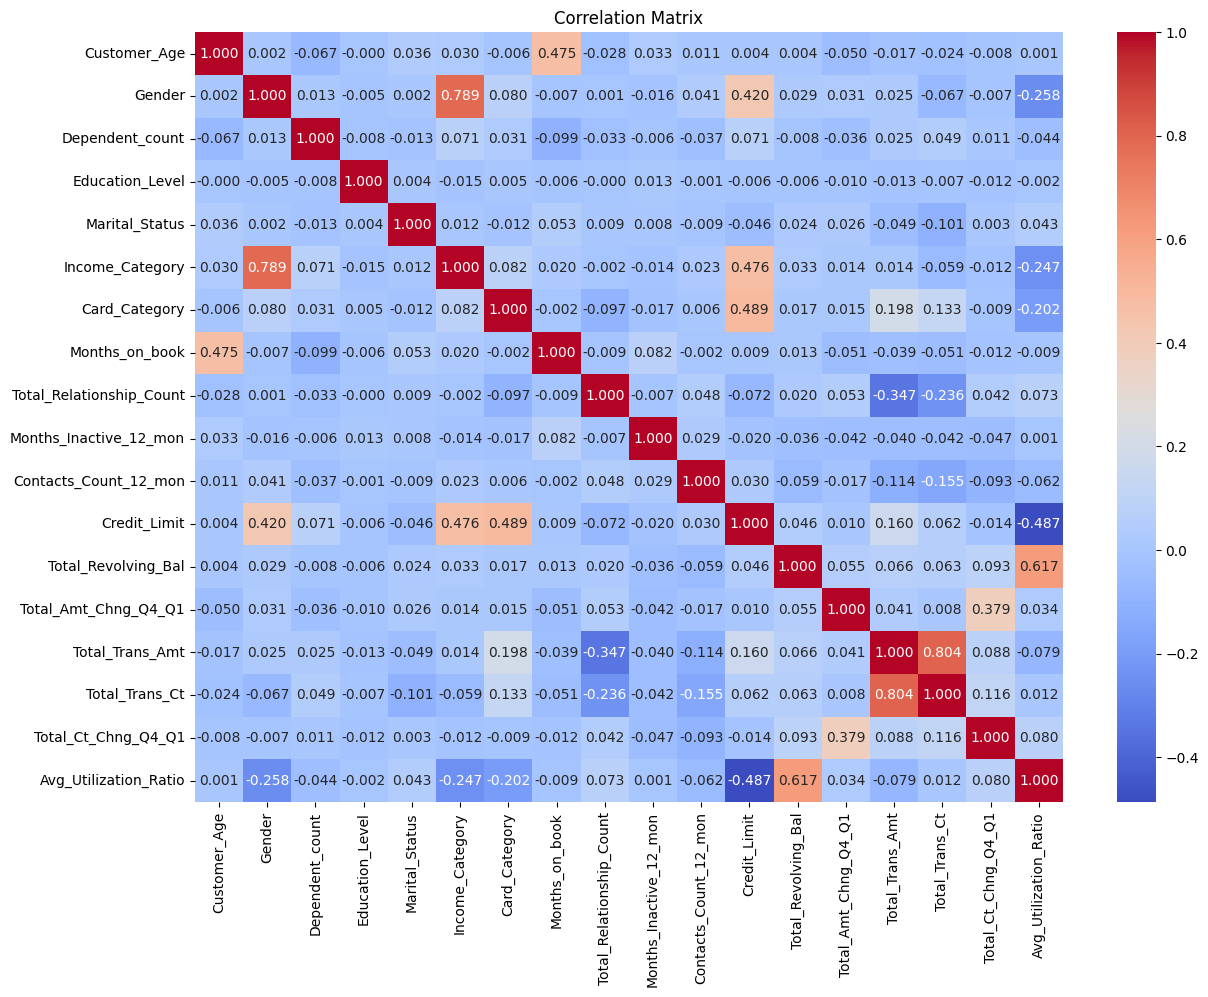

In [12]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

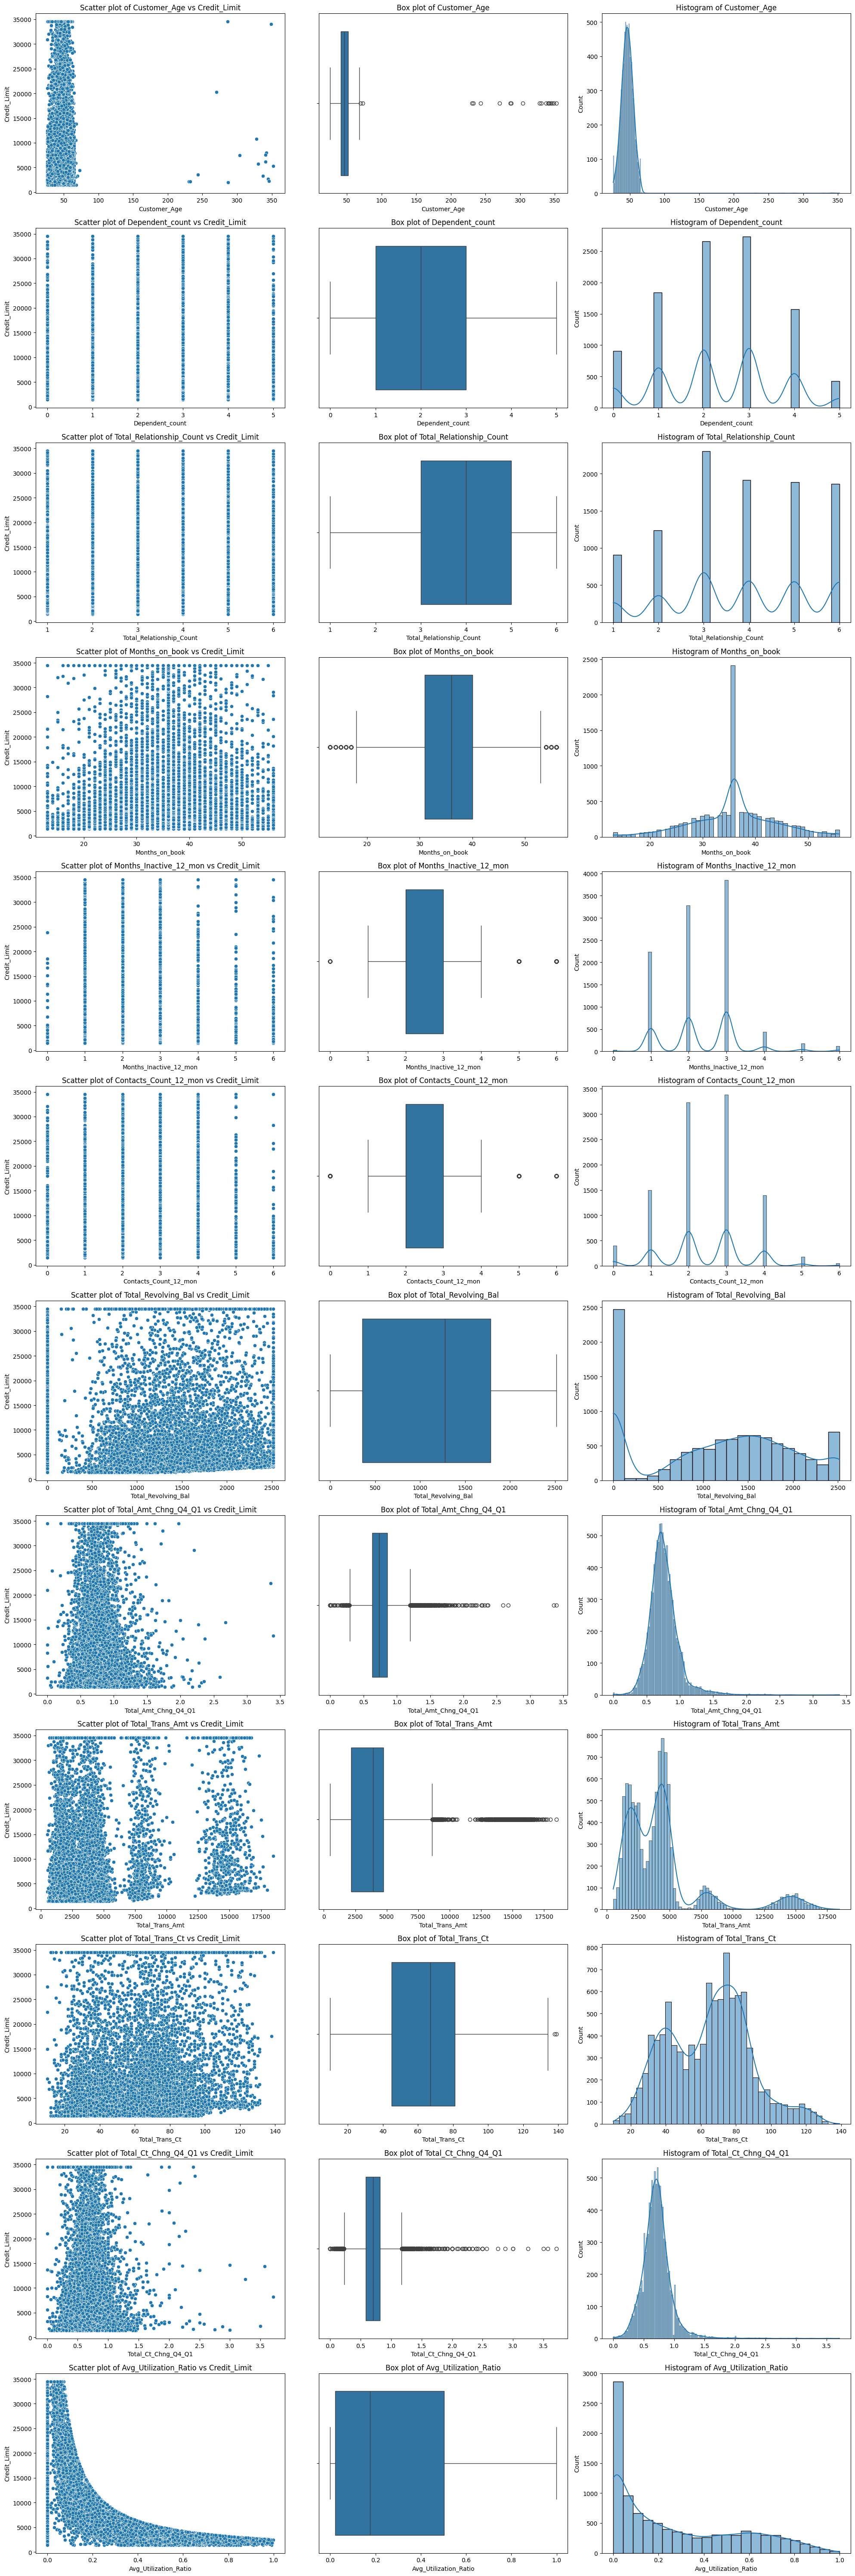

In [13]:
numeric_features = ['Customer_Age', 'Dependent_count', 'Total_Relationship_Count', 'Months_on_book', 
                    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


plt.figure(figsize=(20, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Scatter plot
    plt.subplot(len(numeric_features), 3, 3*i + 1)
    sns.scatterplot(data=df, x=feature, y='Credit_Limit')
    plt.title(f'Scatter plot of {feature} vs Credit_Limit')

    # Box plot to identify out
    plt.subplot(len(numeric_features), 3, 3*i + 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')

    # Histogram to understan distribiution
    plt.subplot(len(numeric_features), 3, 3*i + 3)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

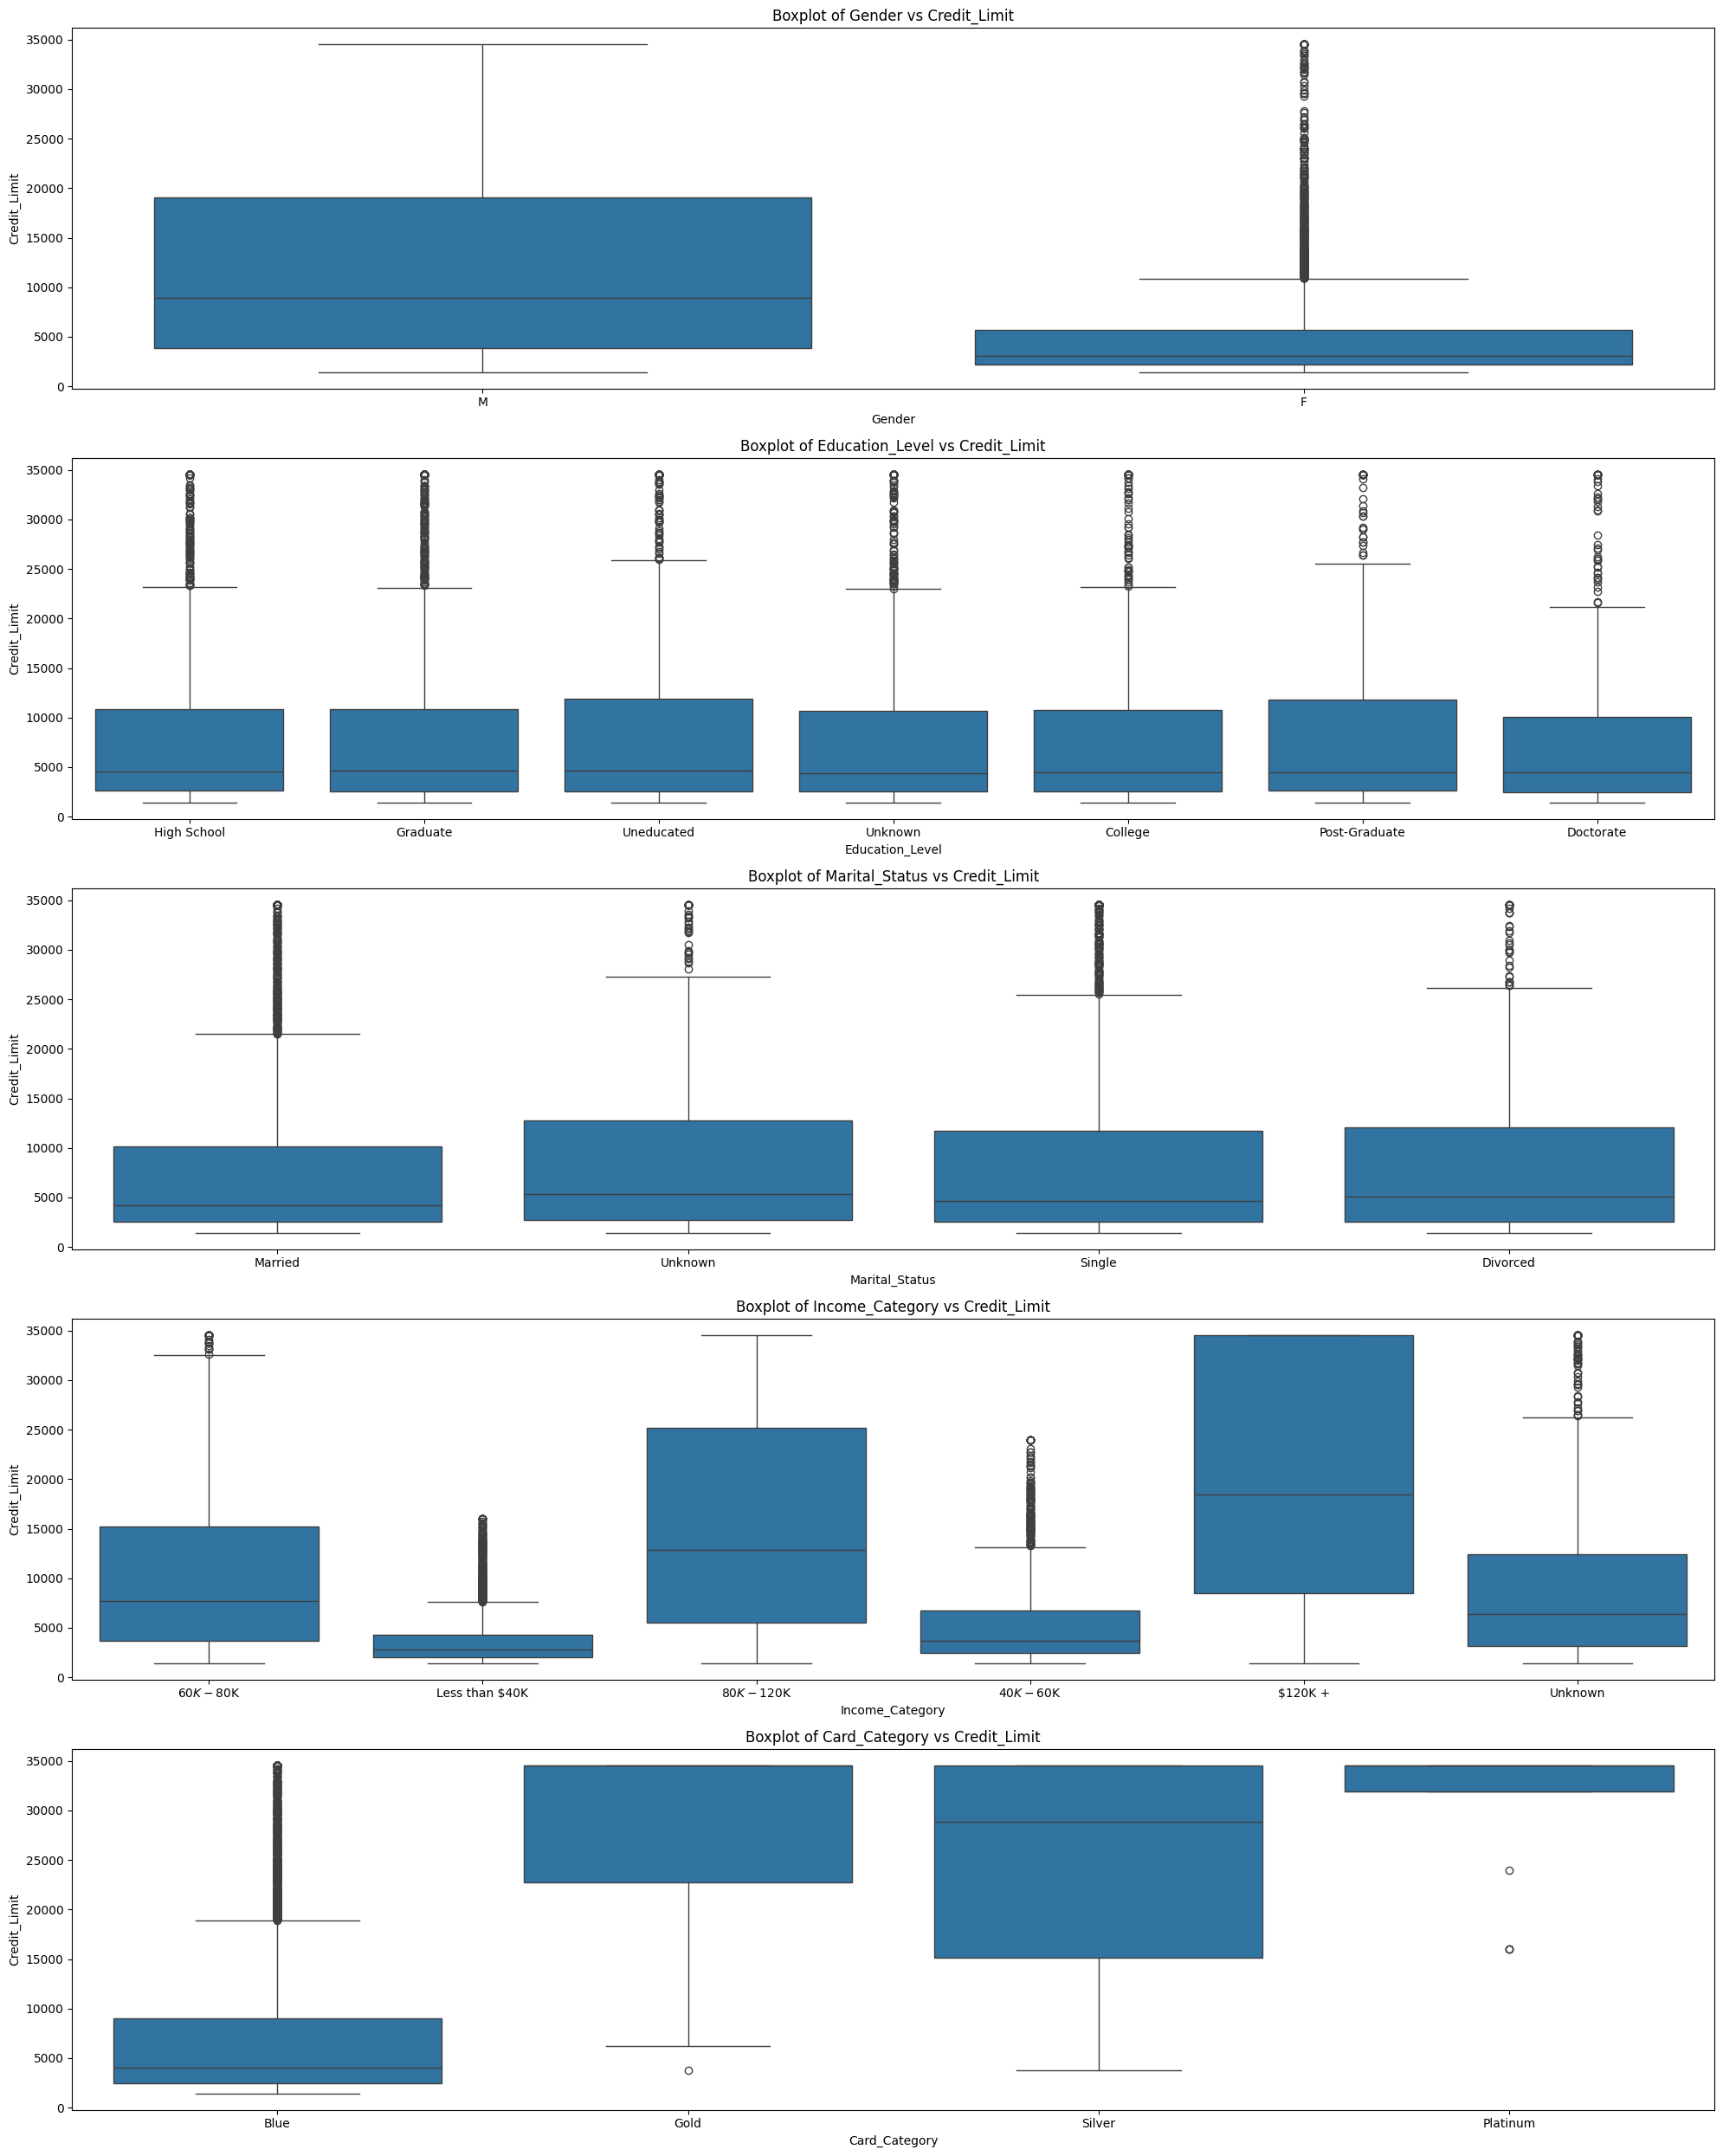

In [14]:
# Identify categorical features
categorical_features = df_copy.select_dtypes(include="object").columns

plt.figure(figsize=(20, 5 * len(categorical_features)))

for i, feature in enumerate(categorical_features):
    # Categorical plot
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.boxplot(data=df_copy, x=feature, y='Credit_Limit')
    plt.title(f'Boxplot of {feature} vs Credit_Limit')

plt.tight_layout()
plt.show()

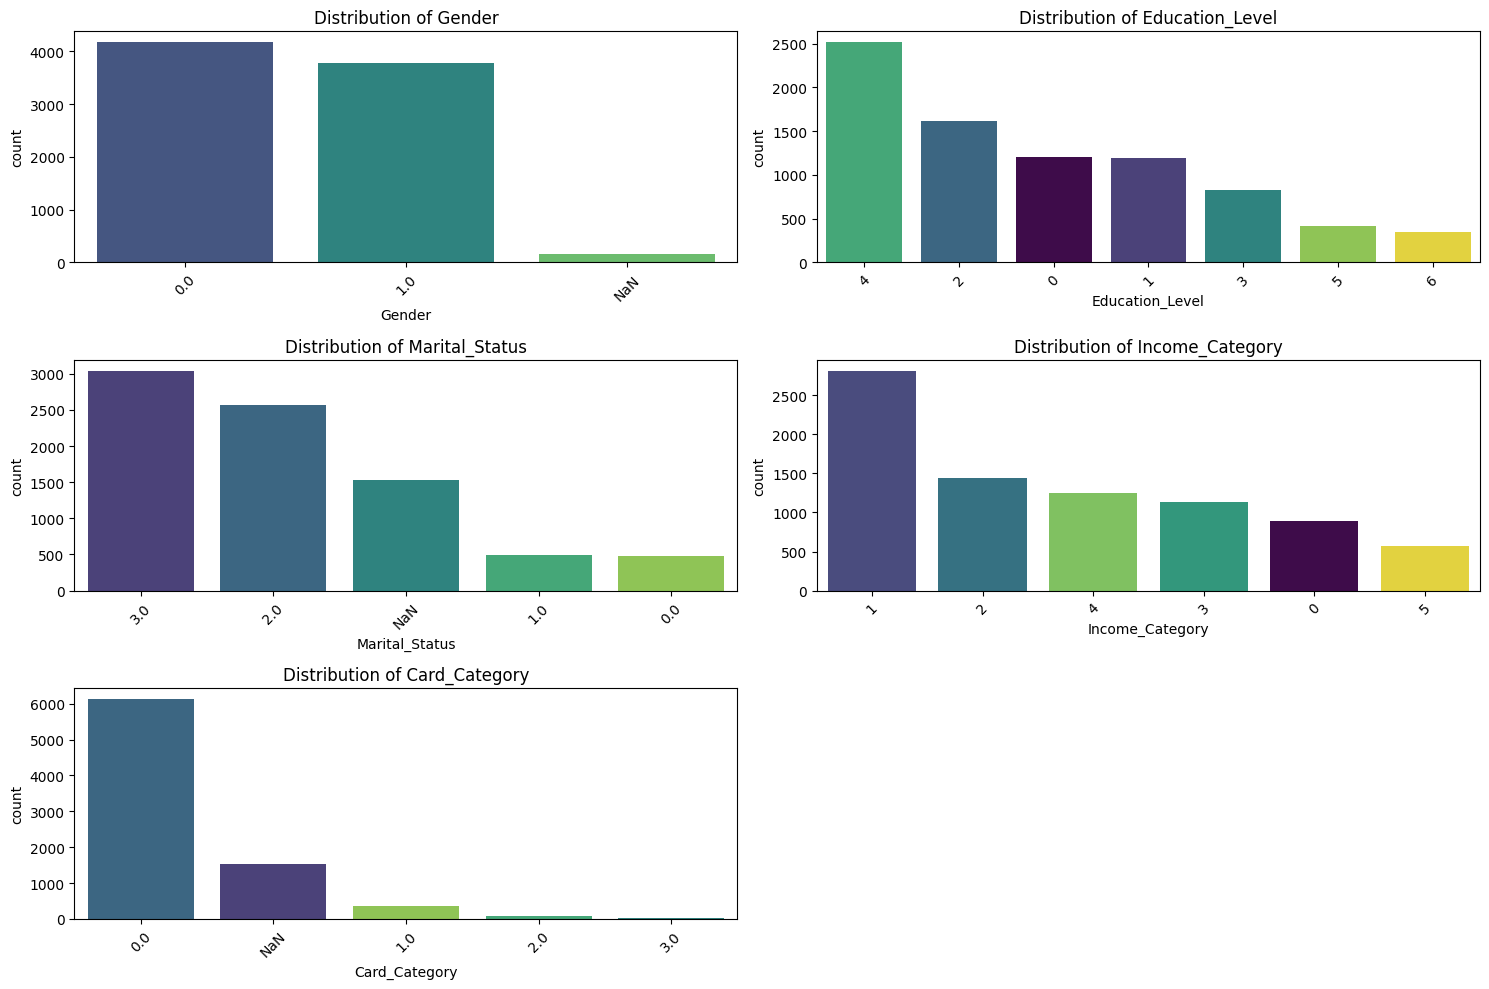

In [15]:
train_df_copy = train_df.copy()
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
train_df_copy[categorical_features] = train_df_copy[categorical_features].fillna('NaN')

# Plot bar plots for each categorical feature including NaN values
plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_df_copy, x=feature, hue=feature, order=train_df_copy[feature].value_counts().index, palette="viridis", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

<Axes: >

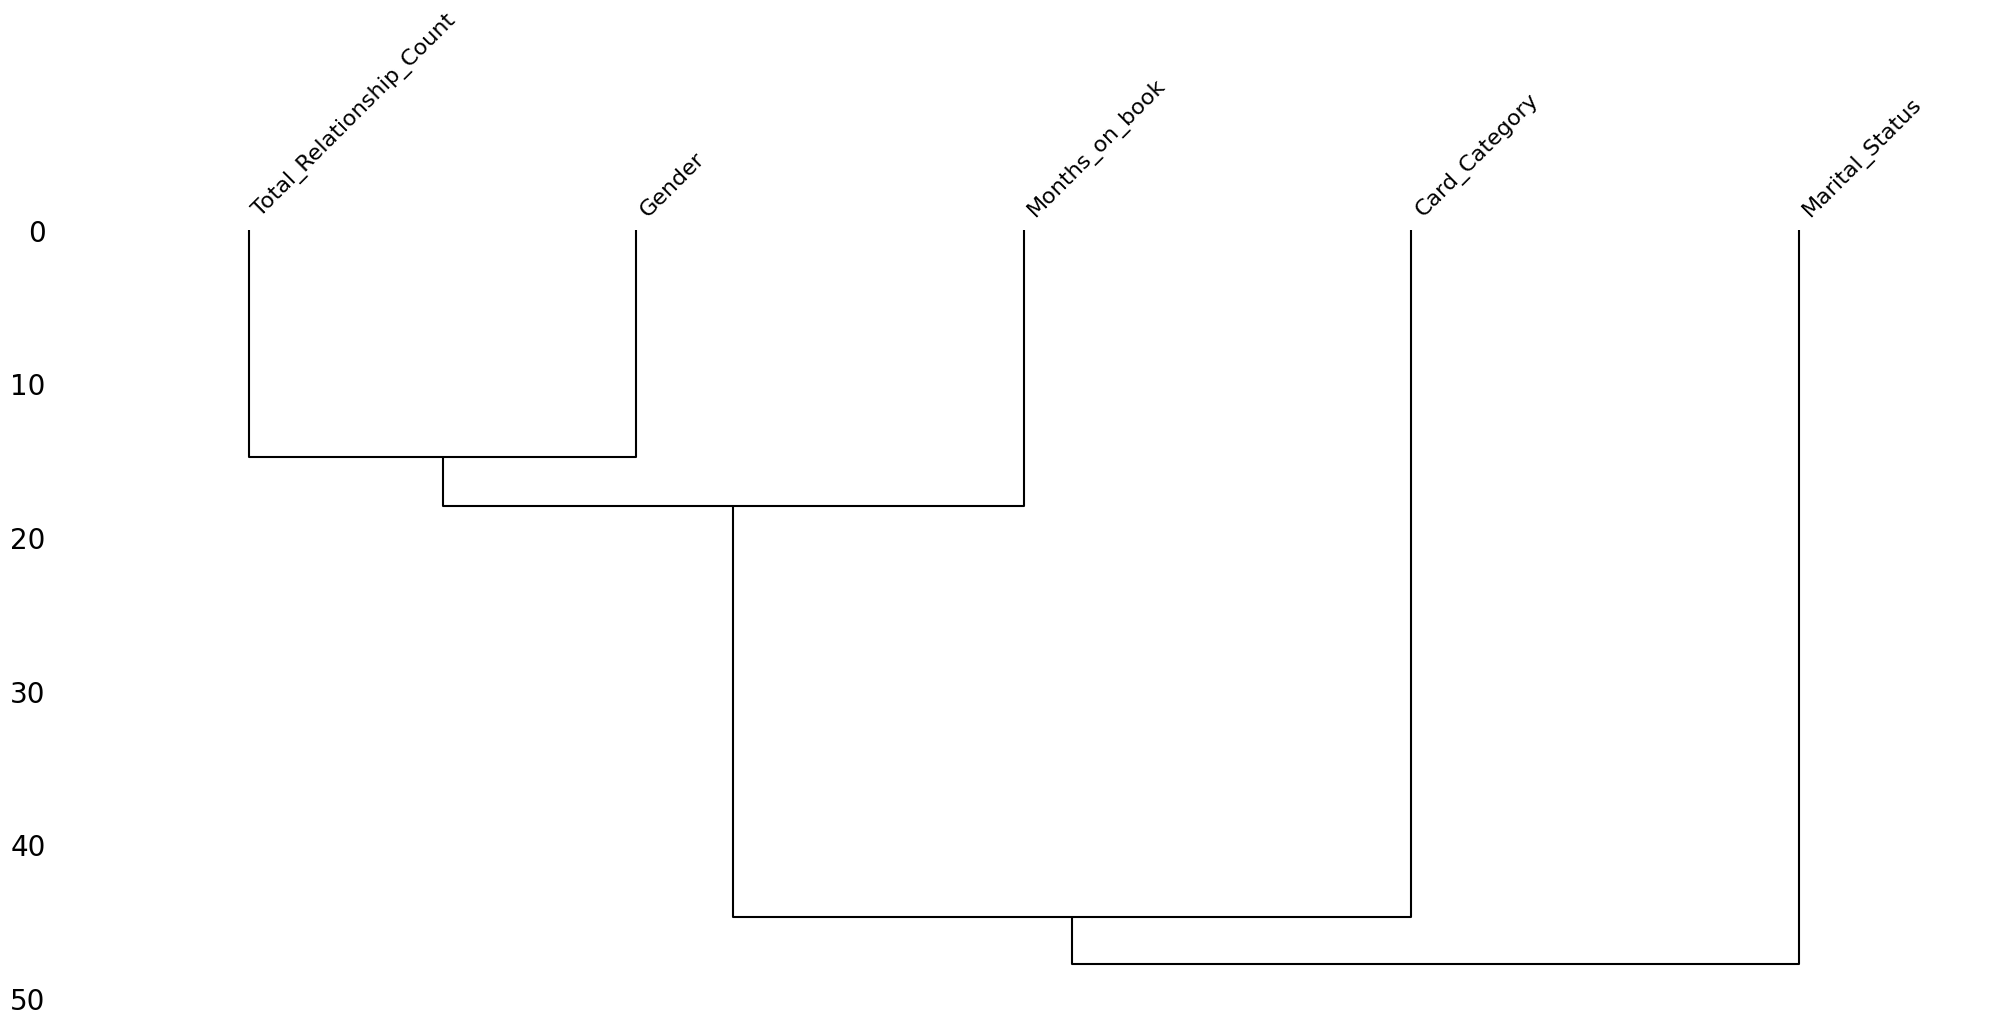

In [16]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
msno.dendrogram(df[missing_columns])


# Missing Values Treatment
____________________________________________________________________________________________________________________

After splitting the data into training and test sets, the next crucial step involves handling missing values in both datasets. Missing data imputation is necessary because regression models cannot handle missing values. 

When addressing missing data, it's crucial to consider factors such as the percentage of missingness, potential reasons for missing values, and the data types involved. 

- **Percentage of Missingness**: Assess the proportion of missing values in each feature to prioritize imputation efforts.

- **Investigating Potential Reasons**: Examine whether missing values are missing at random (MAR), missing completely at random (MCAR), or missing not at random (MNAR) to inform imputation strategies.

- **Data Types Consideration**: Tailor imputation methods based on the data types involved, employing techniques like mean, median, or mode imputation for numerical features and mode imputation for categorical features.

By considering these aspects, a comprehensive strategy for handling missing data can be developed, ensuring accurate and reliable results in subsequent analyses.



By imputing missing values, we ensure that the datasets are complete and ready for subsequent modeling tasks. It's essential to handle missing values consistently across both datasets to maintain data integrity and prevent bias in model performance.


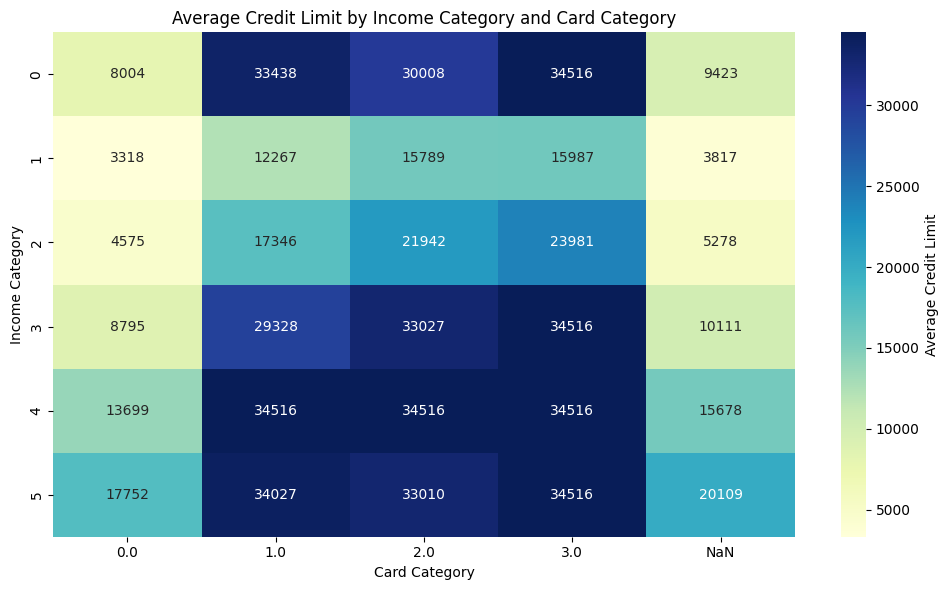

In [17]:
count_by_income_and_card = train_df_copy.groupby(["Income_Category", "Card_Category"]).size()

# Calculate average credit limit by income category and card category
average_limit_by_income_and_card = train_df_copy.groupby(["Income_Category", "Card_Category"])["Credit_Limit"].mean()

# Convert counts and average credit limit to DataFrames
count_df = count_by_income_and_card.reset_index(name='Count')
average_limit_df = average_limit_by_income_and_card.reset_index(name='Avg_Credit_Limit')

# Merge the two DataFrames on income category and card category
merged_df = pd.merge(count_df, average_limit_df, on=["Income_Category", "Card_Category"], how="left")

# Pivot the DataFrame
pivot_df = merged_df.pivot_table(index="Income_Category", columns="Card_Category", values=["Count", "Avg_Credit_Limit"], aggfunc="sum")

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df["Avg_Credit_Limit"], annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Average Credit Limit'})
plt.title('Average Credit Limit by Income Category and Card Category')
plt.xlabel('Card Category')
plt.ylabel('Income Category')
plt.tight_layout()
plt.show()

In [18]:
# Imputing Missing Values in 'Card_Category'
'''
Due to the close relationship between 'Card_Category' and 'Income_Category,'
utilizing their correlation can enhance analysis.
Additionally, since missing 'Credit_Limit' data significantly correlates with the 'Blue' category in 'Card_Category,'
filling missing values with 'Blue' seems reasonable.
'''

train_df['Card_Category'] = train_df['Card_Category'].fillna(0)
test_df['Card_Category'] = test_df['Card_Category'].fillna(0)

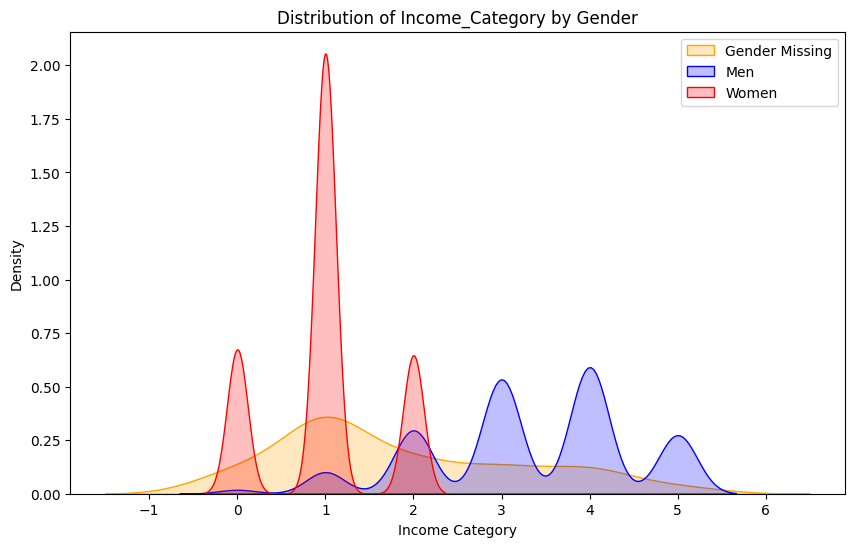

In [19]:
# Create three dataframes: one with missing gender, one for men, and one for women
df_nan_gender = train_df_copy[train_df_copy['Gender'] == 'NaN']
df_men = train_df_copy[(train_df_copy['Gender'] == 1)]
df_women = train_df_copy[(train_df_copy['Gender'] == 0)]

# Plot KDE plots for credit limit distribution for all groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_nan_gender['Income_Category'], label='Gender Missing', fill=True, color='orange')
sns.kdeplot(data=df_men['Income_Category'], label='Men', fill=True, color='blue')
sns.kdeplot(data=df_women['Income_Category'], label='Women', fill=True, color='red')
plt.title('Distribution of Income_Category by Gender')
plt.xlabel('Income Category')
plt.ylabel('Density')
plt.legend()
plt.show()


In [20]:
# Imputing missing 'Gender' values based on 'Income_Category' and 'Card_Category'
'''
Using 'Income_Category' for managing missing values in 'Gender' can be an effective strategy.
For instance, based on the 'Card_Category' and 'Gender' relationship,
we can infer missing 'Gender' values from 'Income_Category'.
'''

train_df.loc[train_df['Card_Category'].isin([3, 4, 5]) & train_df['Gender'].isnull(), 'Gender'] = 1
train_df.loc[train_df['Card_Category'].isin([0, 1, 2]) & train_df['Gender'].isnull(), 'Gender'] = 0

test_df.loc[test_df['Card_Category'].isin([3, 4, 5]) & test_df['Gender'].isnull(), 'Gender'] = 1
test_df.loc[test_df['Card_Category'].isin([0, 1, 2]) & test_df['Gender'].isnull(), 'Gender'] = 0

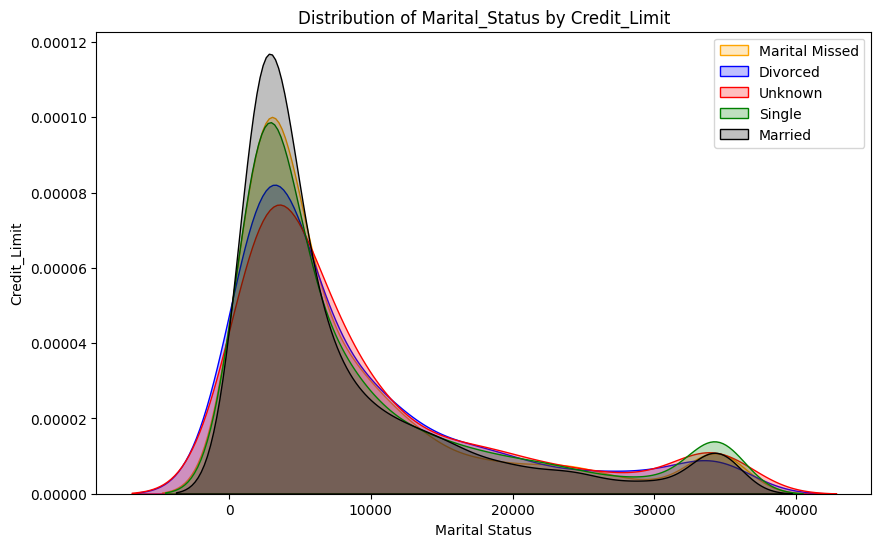

In [21]:
# Create three dataframes: one with missing gender, one for men, and one for women
df_nan_marital = train_df_copy[train_df_copy['Marital_Status'] == 'NaN']
df_divorce = train_df_copy[(train_df_copy['Marital_Status'] == 0)]
df_unknown = train_df_copy[(train_df_copy['Marital_Status'] == 1)]
df_single = train_df_copy[(train_df_copy['Marital_Status'] == 2)]
df_married = train_df_copy[(train_df_copy['Marital_Status'] == 3)]

# Plot KDE plots for credit limit distribution for all groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_nan_marital['Credit_Limit'], label='Marital Missed', fill=True, color='orange')
sns.kdeplot(data=df_divorce['Credit_Limit'], label='Divorced', fill=True, color='blue')
sns.kdeplot(data=df_unknown['Credit_Limit'], label='Unknown', fill=True, color='red')
sns.kdeplot(data=df_single['Credit_Limit'], label='Single', fill=True, color='green')
sns.kdeplot(data=df_married['Credit_Limit'], label='Married', fill=True, color='black')
plt.title('Distribution of Marital_Status by Credit_Limit')
plt.xlabel('Marital Status')
plt.ylabel('Credit_Limit')
plt.legend()
plt.show()


In [22]:
# Imputing missing 'Marital_Status' values with 'Single' (2 represents 'Single' status)
'''
To address missing values in 'Marital_Status',
the relationship between 'Marital_Status' and 'Credit_Limit' has been utilized.
It's observed that single individuals may have a lower inclination to provide marital status information.
Therefore, missing data has been filled with the value representing 'Single'.
'''

train_df['Marital_Status'] = train_df['Marital_Status'].fillna(2)
test_df['Marital_Status'] = test_df['Marital_Status'].fillna(2)

In [23]:
# train_df = Preprocessing.tree_imputation(train_df)
# test_df = Preprocessing.tree_imputation(test_df)

# train_df.head()

In [24]:
# Imputing missing values in other numerical features with the median
'''
For other numerical features, missing values have been filled using the median value.
This imputation strategy ensures that missing data in numerical features is addressed effectively,
maintaining data integrity and minimizing bias in subsequent analyses.

The median is a statistical measure that represents the middle value of a dataset.
It is calculated by arranging all the values in ascending order and selecting the middle value.
If there is an even number of data points, the median is the average of the two middle values.
The median is less sensitive to outliers compared to the mean, making it a robust measure of central tendency,
especially in datasets with skewed distributions.
'''

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(train_df[['Months_on_book']])
train_df['Months_on_book']= imputer.fit_transform(train_df[['Months_on_book']])
test_df['Months_on_book']= imputer.transform(test_df[['Months_on_book']])

imputer.fit(train_df[['Total_Relationship_Count']])
train_df['Total_Relationship_Count']= imputer.fit_transform(train_df[['Total_Relationship_Count']])
test_df['Total_Relationship_Count']= imputer.transform(test_df[['Total_Relationship_Count']])

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    8105 non-null   float64
 2   Dependent_count           8105 non-null   int64  
 3   Education_Level           8105 non-null   int64  
 4   Marital_Status            8105 non-null   float64
 5   Income_Category           8105 non-null   int64  
 6   Card_Category             8105 non-null   float64
 7   Months_on_book            8105 non-null   float64
 8   Total_Relationship_Count  8105 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2027 entries, 7658 to 3739
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              2027 non-null   float64
 1   Gender                    2027 non-null   float64
 2   Dependent_count           2027 non-null   int64  
 3   Education_Level           2027 non-null   int64  
 4   Marital_Status            2027 non-null   float64
 5   Income_Category           2027 non-null   int64  
 6   Card_Category             2027 non-null   float64
 7   Months_on_book            2027 non-null   float64
 8   Total_Relationship_Count  2027 non-null   float64
 9   Months_Inactive_12_mon    2027 non-null   int64  
 10  Contacts_Count_12_mon     2027 non-null   int64  
 11  Credit_Limit              2027 non-null   float64
 12  Total_Revolving_Bal       2027 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      2027 non-null   float64
 14  Total_Tran


# Outlier Detection and Treatment
____________________________________________________________________________________________________________________

Outliers in the dataset can arise due to incorrect entries by users or extreme values in certain features.


Outliers can distort analyses and models. Handling them is crucial for accurate insights. Here's a brief overview:

1. **Identification Methods**: Outliers are detected using statistical methods or ML algorithms. Techniques like Z-score, IQR, or LOF help pinpoint them.

2. **Handling Approaches**:
   - **Removal**: Deleting outliers from the dataset, suitable for errors or anomalies.
   - **Imputation**: Replacing outliers with reasonable estimates like mean or median.


3. **Validation Process**:
   - After treatment, validate changes in summary statistics, visualization patterns, and model performance.

Effective outlier treatment ensures robust analyses and models, providing accurate insights free from the undue influence of extreme data points.
 data points.
m data points.



In [27]:
'''
the 'Customer_Age' feature cannot exceed 125.
If it does, it's considered erroneous data and is replaced with the mean value.
'''

# Detect ages greater than 125 and set them to NaN
train_df['Customer_Age'] = train_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)
# test_df['Customer_Age'] = test_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)

# Impute the missing values
imputer = SimpleImputer(strategy='mean')
train_df['Customer_Age'] = imputer.fit_transform(train_df[['Customer_Age']])
# test_df['Customer_Age'] = imputer.transform(test_df[['Customer_Age']])

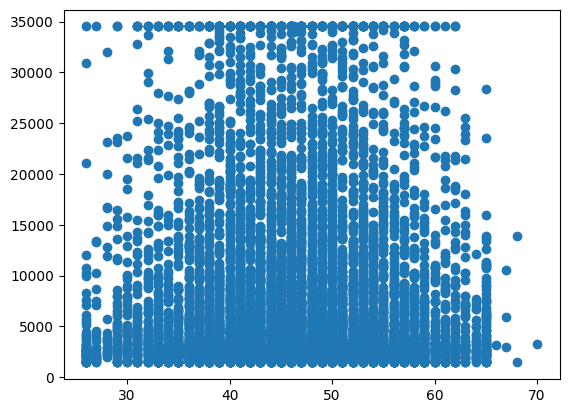

In [28]:
plt.scatter(x='Customer_Age', y='Credit_Limit', data=train_df)

In [29]:

def lof(data, test, feature_x, feature_y, n=5, c=0.05):
    # Extract the features for LOF
    X = data[[feature_x, feature_y]]
    T = test[[feature_x, feature_y]]
    
    # Fit the LOF model
    lof = LocalOutlierFactor(n_neighbors=n, contamination=c)
    lof.fit(X)
    data['outlier'] = lof.fit_predict(X)
    # test['outlier'] = lof.fit_predict(T)
    
    # Identify the outliers
    outliers = data[data['outlier'] == -1]
    inliers = data[data['outlier'] == 1]

    # outliers_test = test[test['outlier'] == -1]
    # inliers_test = test[test['outlier'] == 1]
    
    print("#outlier detected : ", len(outliers))
    
    # Plot scatter plot with outliers highlighted in red
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_x, y=feature_y, data=inliers, label='Inliers')
    sns.scatterplot(x=outliers[feature_x], y=outliers[feature_y], color='red', s=100, label='Outliers')
    plt.title(f'Scatter plot of {feature_x} vs {feature_y} with Outliers')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.show()

    return data, test


#outlier detected :  33


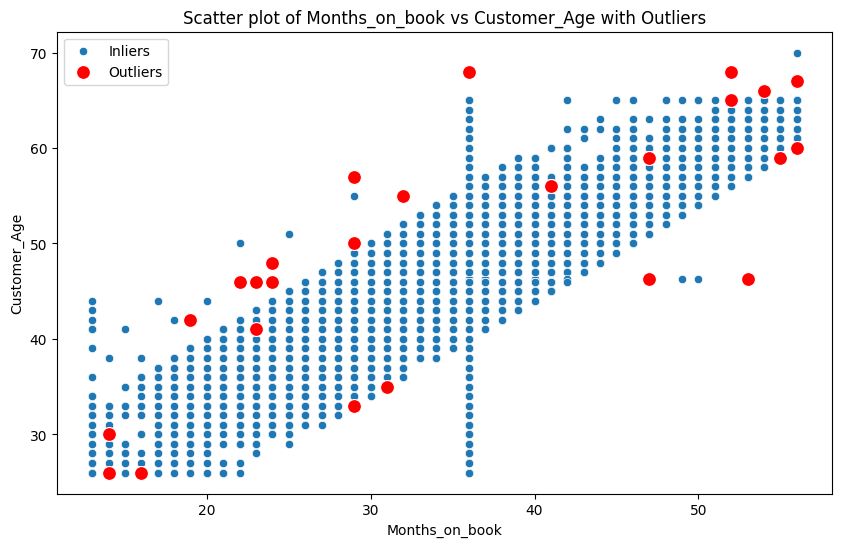

In [30]:
'''
We use the age variable to detect outliers in the 'Months_on_book' feature based on their covariance matrix.
This method leverages the relationship between age and the duration of the banking relationship 
to identify anomalies in the 'Months_on_book' feature.
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Months_on_book', 'Customer_Age', 5, 0.006)

In [31]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

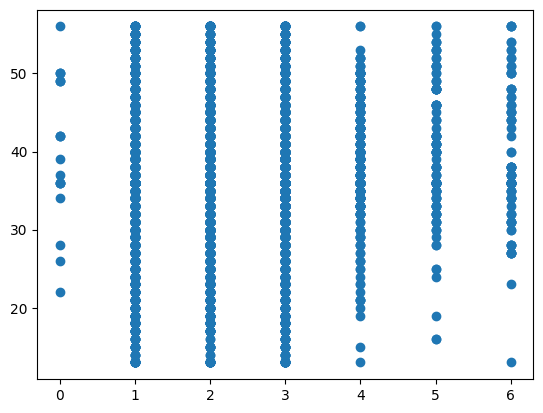

In [32]:
plt.scatter(x='Months_Inactive_12_mon', y='Months_on_book', data=train_df)

#outlier detected :  29


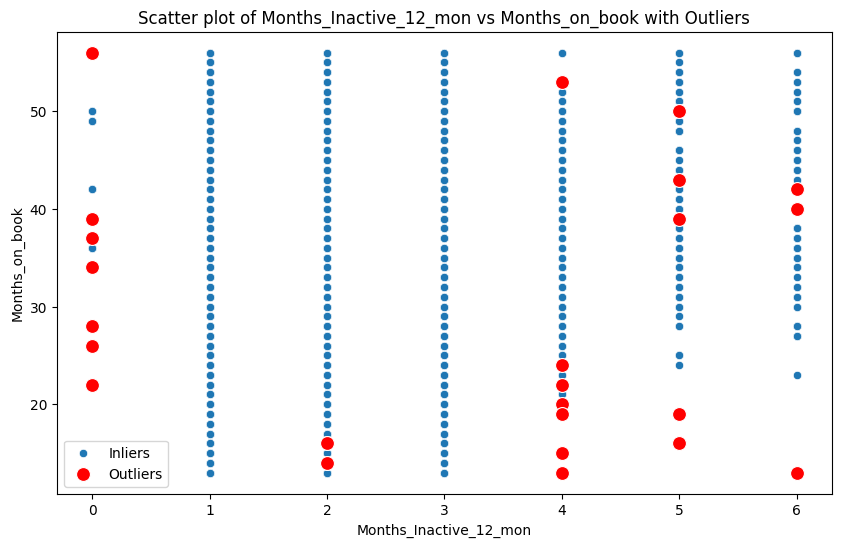

In [33]:
'''
We use the length of time a customer has been with the bank ('Months_on_book')
to identify outliers in their level of inactivity ('Months_Inactive_12_mon').
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Months_Inactive_12_mon', 'Months_on_book', 5, 0.005)

In [34]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

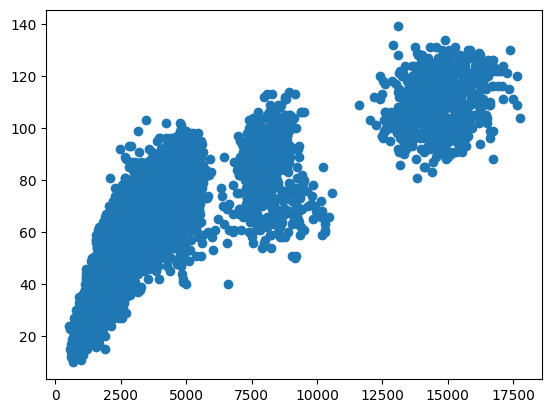

In [35]:
plt.scatter(x='Total_Trans_Amt', y='Total_Trans_Ct', data=train_df)

#outlier detected :  81


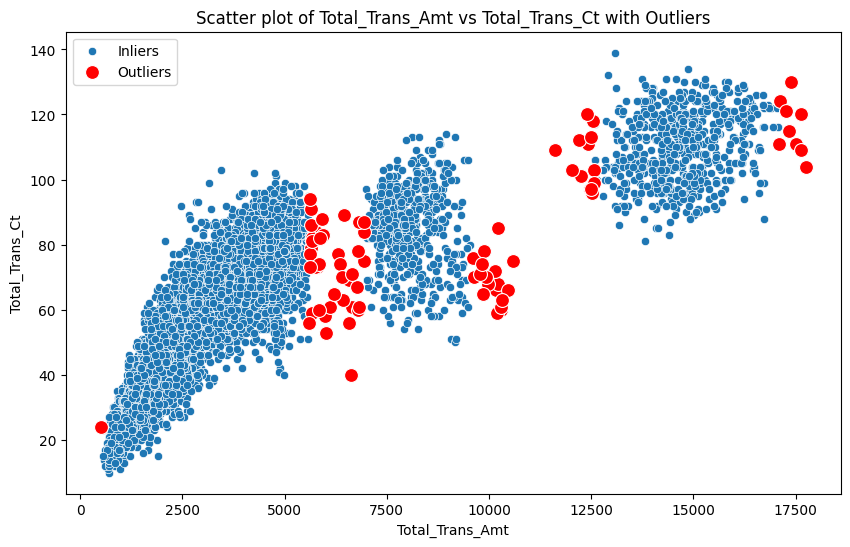

In [36]:
'''
It seems we can detect outliers of 'Total_Trans_Amt' and 'Total_Trans_Ct' together based on their covariance matrix.
This suggests that these two features have a significant relationship that can help
identify outliers more effectively when considered together.
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Trans_Amt', 'Total_Trans_Ct', 100, 0.01)

In [37]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

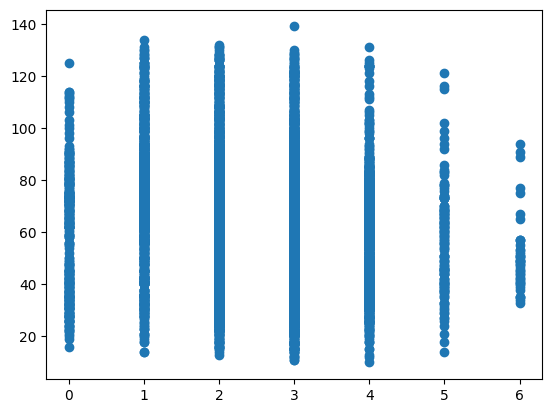

In [38]:
plt.scatter(x='Contacts_Count_12_mon', y='Total_Trans_Ct', data=train_df)

#outlier detected :  29


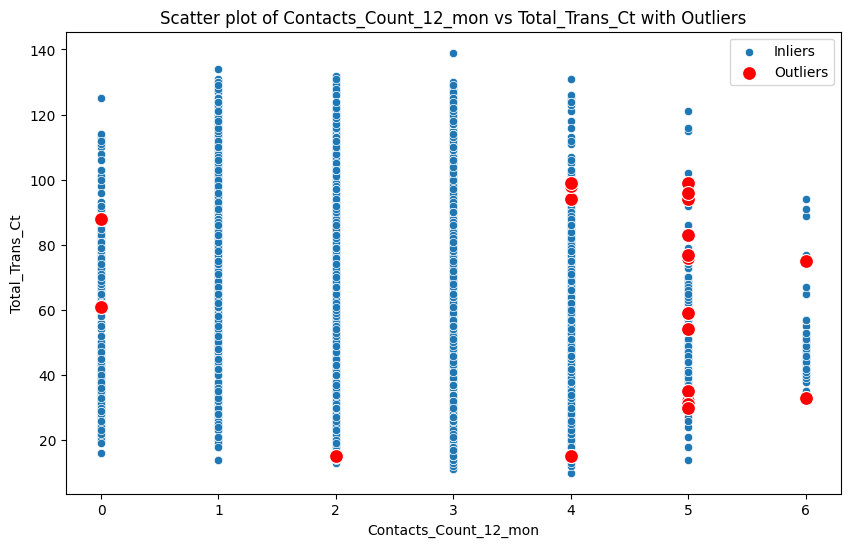

In [39]:
'''
After detecting outliers in 'Total_Trans_Ct', we use this information to detect outliers in 'Contacts_Count_12_mon'
as well. By considering the relationship between these two features, we can identify outliers more accurately.
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Contacts_Count_12_mon', 'Total_Trans_Ct', 10, 0.005)

In [40]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

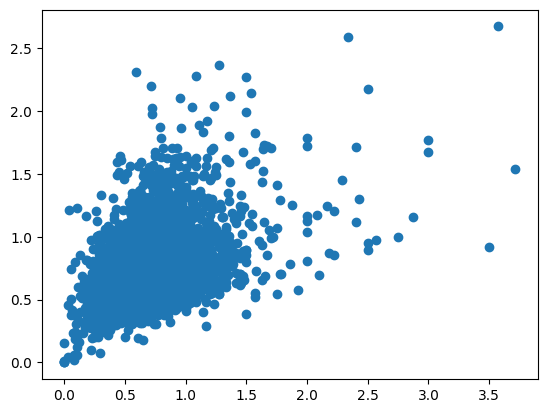

In [41]:
plt.scatter(x='Total_Ct_Chng_Q4_Q1', y='Total_Amt_Chng_Q4_Q1', data=train_df)

#outlier detected :  119


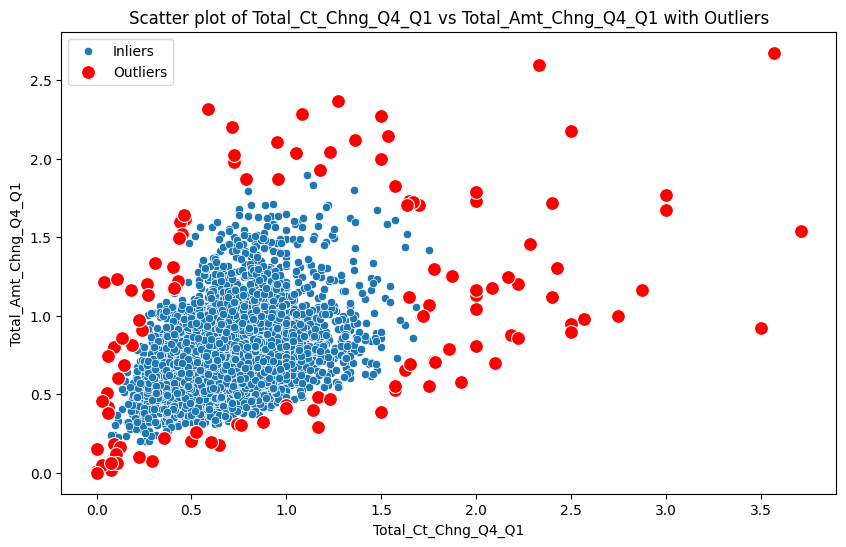

In [42]:
'''
We apply the LOF to detect outliers jointly in 'Total_Ct_Chng_Q4_Q1' and 'Total_Amt_Chng_Q4_Q1'.
By considering these two features together, we can capture any anomalies in customer behavior
that may be reflected in changes in both transaction count and transaction amount between quarters.
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1', 50, 0.015)

In [43]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

In [44]:
print(train_df.shape)

(7814, 18)


In [45]:
train_df.describe().T

count         mean          std       min  \
Customer_Age              7814.0    46.271537     7.939220    26.000   
Gender                    7814.0     0.463399     0.498690     0.000   
Dependent_count           7814.0     2.354492     1.293985     0.000   
Education_Level           7814.0     2.597773     1.692652     0.000   
Marital_Status            7814.0     2.197722     0.794155     0.000   
Income_Category           7814.0     2.090607     1.473511     0.000   
Card_Category             7814.0     0.067827     0.304842     0.000   
Months_on_book            7814.0    35.914512     7.792530    13.000   
Total_Relationship_Count  7814.0     3.812004     1.553963     1.000   
Months_Inactive_12_mon    7814.0     2.338111     1.002538     0.000   
Contacts_Count_12_mon     7814.0     2.446890     1.094034     0.000   
Credit_Limit              7814.0  8535.543460  9001.314042  1438.300   
Total_Revolving_Bal       7814.0  1168.188508   811.766501     0.000   
Total_Amt_Chng_Q4_Q1      7814.0     0.755255     0.197084     0.198   
Total_Trans_Amt           7814.0  4412.745713  3360.956272   563.000   
Total_Trans_Ct            7814.0    65.390965    23.209546    10.000   
Total_Ct_Chng_Q4_Q1       7814.0     0.704470     0.202122     0.074   
Avg_Utilization_Ratio     7814.0     0.278479     0.276064     0.000   

                               25%       50%          75%        max  
Customer_Age                41.000    46.000     52.00000     70.000  
Gender                       0.000     0.000      1.00000      1.000  
Dependent_count              1.000     2.000      3.00000      5.000  
Education_Level              1.000     3.000      4.00000      6.000  
Marital_Status               2.000     2.000      3.00000      3.000  
Income_Category              1.000     2.000      3.00000      5.000  
Card_Category                0.000     0.000      0.00000      3.000  
Months_on_book              32.000    36.000     40.00000     56.000  
Total_Relationship_Count     3.000     4.000      5.00000      6.000  
Months_Inactive_12_mon       2.000     2.000      3.00000      6.000  
Contacts_Count_12_mon        2.000     2.000      3.00000      6.000  
Credit_Limit              2525.500  4511.500  10897.25000  34516.000  
Total_Revolving_Bal        470.250  1279.500   1783.00000   2517.000  
Total_Amt_Chng_Q4_Q1         0.631     0.735      0.85575      1.893  
Total_Trans_Amt           2198.000  3924.000   4738.75000  17064.000  
Total_Trans_Ct              46.000    68.000     81.00000    139.000  
Total_Ct_Chng_Q4_Q1          0.583     0.700      0.81600      1.750  
Avg_Utilization_Ratio        0.028     0.181      0.51075      0.995

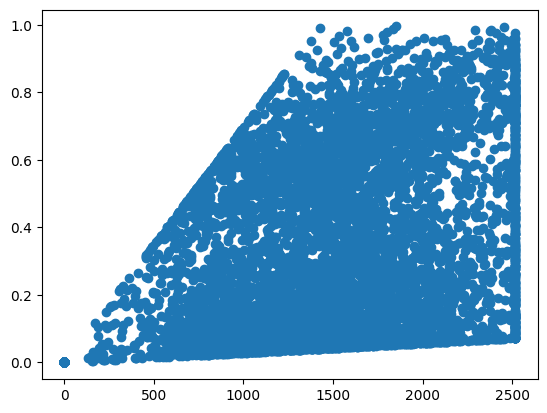

In [46]:
plt.scatter(x='Total_Revolving_Bal', y='Avg_Utilization_Ratio', data=train_df)

#outlier detected :  391


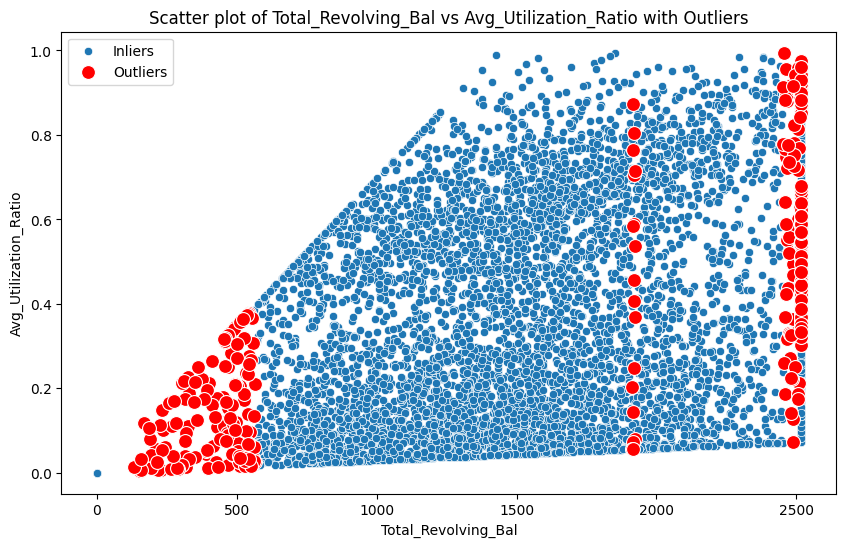

In [47]:
'''
identify outliers jointly in the 'Total_Revolving_Bal' and 'Avg_Utilization_Ratio' features.
By analyzing these features together, we aim to capture any irregularities in revolving balance and
credit card utilization ratio.
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Total_Revolving_Bal', 'Avg_Utilization_Ratio', 100, 0.05)

In [48]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

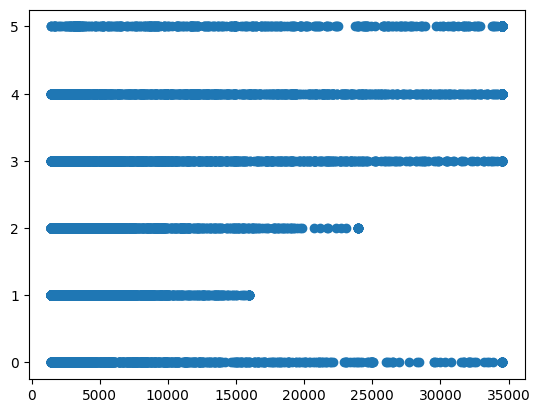

In [49]:
plt.scatter(x='Credit_Limit', y='Income_Category', data=train_df)

#outlier detected :  372


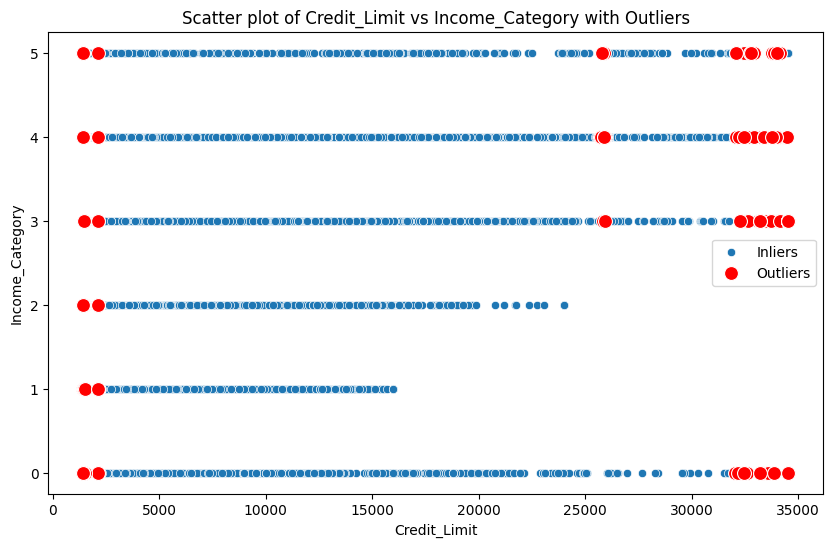

In [50]:
'''
detect outliers jointly in the 'Credit_Limit' and 'Income_Category' features, considering their covariance.
This approach helps us identify any unusual combinations of credit limits and income categories
that deviate from the expected patterns in the dataset
'''

outlier_train, outlier_test = lof(train_df.copy(), test_df.copy() , 'Credit_Limit', 'Income_Category', 100, 0.05)

In [51]:
train_df = train_df[outlier_train['outlier'] != -1]
# test_df = test_df[outlier_test['outlier'] != -1]

In [52]:
train_df.describe().T

count         mean          std       min  \
Customer_Age              7051.0    46.221101     7.919221    26.000   
Gender                    7051.0     0.468586     0.499048     0.000   
Dependent_count           7051.0     2.352149     1.291687     0.000   
Education_Level           7051.0     2.591547     1.687487     0.000   
Marital_Status            7051.0     2.205503     0.788501     0.000   
Income_Category           7051.0     2.101120     1.475036     0.000   
Card_Category             7051.0     0.057864     0.273768     0.000   
Months_on_book            7051.0    35.858176     7.801911    13.000   
Total_Relationship_Count  7051.0     3.831513     1.549918     1.000   
Months_Inactive_12_mon    7051.0     2.336123     1.001799     0.000   
Contacts_Count_12_mon     7051.0     2.437668     1.090992     0.000   
Credit_Limit              7051.0  8387.680882  8546.904071  1438.300   
Total_Revolving_Bal       7051.0  1161.738193   788.124240     0.000   
Total_Amt_Chng_Q4_Q1      7051.0     0.756057     0.197790     0.198   
Total_Trans_Amt           7051.0  4442.990923  3388.815260   563.000   
Total_Trans_Ct            7051.0    65.752517    23.211880    10.000   
Total_Ct_Chng_Q4_Q1       7051.0     0.706820     0.202007     0.074   
Avg_Utilization_Ratio     7051.0     0.276259     0.272817     0.000   

                                25%       50%        75%        max  
Customer_Age                41.0000    46.000     52.000     70.000  
Gender                       0.0000     0.000      1.000      1.000  
Dependent_count              1.0000     2.000      3.000      5.000  
Education_Level              1.0000     3.000      4.000      6.000  
Marital_Status               2.0000     2.000      3.000      3.000  
Income_Category              1.0000     2.000      3.000      5.000  
Card_Category                0.0000     0.000      0.000      3.000  
Months_on_book              32.0000    36.000     40.000     56.000  
Total_Relationship_Count     3.0000     4.000      5.000      6.000  
Months_Inactive_12_mon       2.0000     2.000      3.000      6.000  
Contacts_Count_12_mon        2.0000     2.000      3.000      6.000  
Credit_Limit              2588.5000  4637.000  10947.500  34516.000  
Total_Revolving_Bal        610.0000  1293.000   1753.000   2517.000  
Total_Amt_Chng_Q4_Q1         0.6315     0.735      0.856      1.893  
Total_Trans_Amt           2212.5000  3944.000   4740.000  17064.000  
Total_Trans_Ct              46.0000    68.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.5870     0.702      0.818      1.750  
Avg_Utilization_Ratio        0.0290     0.181      0.504      0.995

In [53]:
'''
Categorical data provides the limits of the data needed from the user by giving out the range of the expected data,
so, all the users will provide the required data.
Outliers come in when the data requested from the users is open-ended, i.e, anybody can enter anything.
'''

# For unusual or unexpected observations within categorical data: use SVM for anomaly detection

# Train the OC-SVM model on the training data
clf = OneClassSVM(nu=0.8, kernel='rbf', gamma='auto')
clf.fit(train_df)

# Detect anomalies in the training data
train_anomaly_scores = clf.decision_function(train_df)
train_anomalies_idx = np.where(train_anomaly_scores < 0)[0]

# Remove anomalies from the training data
train_df = train_df.drop(train_df.index[train_anomalies_idx])


In [54]:
print(train_df.shape)
print(test_df.shape)

(5064, 18)
(2027, 18)



# Feature Selection
____________________________________________________________________________________________________________________

In feature selection, we employ two approaches:

1. **VIF Importance:**
   - Calculate the Variance Inflation Factor (VIF) for each feature to identify highly correlated features.
   - Remove features with high VIF values as they indicate multicollinearity.
  
2. **Random Forest Feature Importance:**
    - Train a Random Forest model to assess feature importance.
    - Sort features based on their importance scores.
    - Retain only the most significant features for further analysis.


In [55]:
def vif_importance(data):

    vif_data = pd.DataFrame()
    vif_data['Feature'] = train_df.columns
    vif_data['VIF'] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
    
    
    X = train_df.drop('Credit_Limit', axis='columns')
    y = train_df['Credit_Limit']
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    combined_data = pd.merge(feature_importances, vif_data, on='Feature', how='inner')
    
    info = combined_data.sort_values(by='Importance', ascending=False)
    return info

In [56]:
info = vif_importance(train_df)

In [57]:
(info) 

Feature  Importance        VIF
0      Avg_Utilization_Ratio    0.420781   6.062172
1            Income_Category    0.239581   8.630447
2        Total_Revolving_Bal    0.163871   7.174995
3              Card_Category    0.061275   1.296993
4            Total_Trans_Amt    0.016861   8.821232
5       Total_Amt_Chng_Q4_Q1    0.015222  16.236073
6        Total_Ct_Chng_Q4_Q1    0.014307  15.424124
7             Total_Trans_Ct    0.012174  25.031854
8               Customer_Age    0.010757  76.824692
9             Months_on_book    0.010366  57.213571
10  Total_Relationship_Count    0.007021   7.831607
11           Education_Level    0.006195   3.251686
12     Contacts_Count_12_mon    0.005856   5.587047
13           Dependent_count    0.004754   4.209314
14    Months_Inactive_12_mon    0.004551   6.314962
15            Marital_Status    0.004440   8.258021
16                    Gender    0.001987   4.977622

In [58]:
'''
                     Feature  Importance        VIF
0      Avg_Utilization_Ratio    0.423976   5.733280
1            Income_Category    0.217079   8.463035
2        Total_Revolving_Bal    0.158359   6.818633
3              Card_Category    0.085800   1.368058
4            Total_Trans_Amt    0.018901   8.875106
5        Total_Ct_Chng_Q4_Q1    0.015670  15.430608
6       Total_Amt_Chng_Q4_Q1    0.014443  16.485472
7             Total_Trans_Ct    0.012514  25.027169
8             Months_on_book    0.010501  57.502447
9               Customer_Age    0.009608  78.541473
10  Total_Relationship_Count    0.006471   7.730422
11           Education_Level    0.006031   3.255891
12           Dependent_count    0.005262   4.203624
13    Months_Inactive_12_mon    0.004799   6.235826
14     Contacts_Count_12_mon    0.004763   5.713434
15            Marital_Status    0.004356   8.347183
16                    Gender    0.001466   4.916800

'''

'\n                     Feature  Importance        VIF\n0      Avg_Utilization_Ratio    0.423976   5.733280\n1            Income_Category    0.217079   8.463035\n2        Total_Revolving_Bal    0.158359   6.818633\n3              Card_Category    0.085800   1.368058\n4            Total_Trans_Amt    0.018901   8.875106\n5        Total_Ct_Chng_Q4_Q1    0.015670  15.430608\n6       Total_Amt_Chng_Q4_Q1    0.014443  16.485472\n7             Total_Trans_Ct    0.012514  25.027169\n8             Months_on_book    0.010501  57.502447\n9               Customer_Age    0.009608  78.541473\n10  Total_Relationship_Count    0.006471   7.730422\n11           Education_Level    0.006031   3.255891\n12           Dependent_count    0.005262   4.203624\n13    Months_Inactive_12_mon    0.004799   6.235826\n14     Contacts_Count_12_mon    0.004763   5.713434\n15            Marital_Status    0.004356   8.347183\n16                    Gender    0.001466   4.916800\n\n'

In [59]:
'''
Based on the results, the following features were removed:

- Gender: Due to its lowest importance.
- Marital_Status: Due to low importance and nonlinear correlation exceeding 5.
- Months_Inactive_12_mon: Due to low importance and its correlation with 'Months_Cont_Contacts'.
- Customer_Age: Due to its highly nonlinear correlation with other features.
'''

columns_to_remove = ['Gender', 'Marital_Status', 'Months_Inactive_12_mon', 'Customer_Age']
# 'Total_Trans_Ct', 'Total_Amt_Chng_Q4_Q1' ?

In [60]:
train_df = train_df.drop(columns_to_remove, axis='columns')
test_df = test_df.drop(columns_to_remove, axis='columns')

In [61]:
print(train_df.shape)

(5064, 14)


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5064 entries, 7402 to 7270
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           5064 non-null   int64  
 1   Education_Level           5064 non-null   int64  
 2   Income_Category           5064 non-null   int64  
 3   Card_Category             5064 non-null   float64
 4   Months_on_book            5064 non-null   float64
 5   Total_Relationship_Count  5064 non-null   float64
 6   Contacts_Count_12_mon     5064 non-null   int64  
 7   Credit_Limit              5064 non-null   float64
 8   Total_Revolving_Bal       5064 non-null   int64  
 9   Total_Amt_Chng_Q4_Q1      5064 non-null   float64
 10  Total_Trans_Amt           5064 non-null   int64  
 11  Total_Trans_Ct            5064 non-null   int64  
 12  Total_Ct_Chng_Q4_Q1       5064 non-null   float64
 13  Avg_Utilization_Ratio     5064 non-null   float64
dtypes: float64

In [63]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2027 entries, 7658 to 3739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           2027 non-null   int64  
 1   Education_Level           2027 non-null   int64  
 2   Income_Category           2027 non-null   int64  
 3   Card_Category             2027 non-null   float64
 4   Months_on_book            2027 non-null   float64
 5   Total_Relationship_Count  2027 non-null   float64
 6   Contacts_Count_12_mon     2027 non-null   int64  
 7   Credit_Limit              2027 non-null   float64
 8   Total_Revolving_Bal       2027 non-null   int64  
 9   Total_Amt_Chng_Q4_Q1      2027 non-null   float64
 10  Total_Trans_Amt           2027 non-null   int64  
 11  Total_Trans_Ct            2027 non-null   int64  
 12  Total_Ct_Chng_Q4_Q1       2027 non-null   float64
 13  Avg_Utilization_Ratio     2027 non-null   float64
dtypes: float64

In [64]:
# # PCA

# pca = PCA(n_components=10)  # Set the number of principal components
# x_train = pca.fit_transform(train_df.drop('Credit_Limit', axis='columns'))
# x_test = pca.transform(test_df.drop('Credit_Limit', axis='columns'))


# Scaling
____________________________________________________________________________________________________________________

After completing the necessary steps, it's essential to normalize the train_x and test_x data before processing because different features may have different ranges. There is no need to normalize the labels since it's a single continuous variable, and its range is undefined in the test set, making scaling meaningless.

For scaling the data, the MinMaxScaler method was utilized. This method assumes that the data follows a linear distribution.



In [65]:
x_train = train_df.drop('Credit_Limit', axis='columns')
x_test = test_df.drop('Credit_Limit', axis='columns')

y_train = train_df['Credit_Limit']
y_test = test_df['Credit_Limit']

In [66]:
print(f"x_train : {x_train.shape}")
print(f"y_train : {y_train.shape}")

x_train : (5064, 13)
y_train : (5064,)


In [67]:
x_train, x_test = Preprocessing.scale(x_train, x_test)

In [68]:
print(x_train)

[[0.4        0.66666667 0.2        ... 0.34645669 0.34188544 0.        ]
 [0.         0.         0.2        ... 0.19685039 0.1473747  0.        ]
 [0.4        0.         0.2        ... 0.53543307 0.37470167 0.        ]
 ...
 [1.         1.         1.         ... 0.49606299 0.67541766 0.05929648]
 [0.6        0.33333333 0.         ... 0.23622047 0.14200477 0.        ]
 [0.8        0.33333333 0.6        ... 0.62992126 0.3221957  0.        ]]



# Tain Model and Evaluate


In [69]:

# Define models with their respective parameters
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.8),
    "Polynomial Regression": Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression())
    ])
}

# Train and evaluate models
results_test = []
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)  # Predict on the test set
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)  # Calculate MSE on the test set
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)  # Calculate R2 on the test set
    results_test.append([name, mse_train, r2_train, mse_test, r2_test])

# Create dataframe from results
results_test_df = pd.DataFrame(results_test, columns=["Model", "Train MSE", "Train R2", "Test MSE", "Test R2"])
results_test_df = results_test_df.sort_values(by="Train R2", ascending=False)
results_test_df

Model     Train MSE  Train R2      Test MSE   Test R2
0          Random Forest  1.253357e+06  0.982717  1.266337e+07  0.851246
3  Polynomial Regression  1.012446e+07  0.860389  3.010598e+07  0.646350
1      Linear Regression  2.948030e+07  0.593483  3.622185e+07  0.574508
2       Ridge Regression  2.948209e+07  0.593458  3.627357e+07  0.573901

In [70]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
# rf.fit(x_train, y_train)
        
# oob_score = rf.oob_score_
# print(f'Out-of-Bag Score: {oob_score}')
        
# y_pred = rf.predict(x_test)
        
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error (MSE): {mse}')
        
# r2 = r2_score(y_test, y_pred)
# print(f'R-squared (R2): {r2}')

In [71]:
'''

Out-of-Bag Score: 0.8871661646762087
Mean Squared Error (MSE): 9697483.072144547
R-squared (R2): 0.8860854003358002

'''

'\n\nOut-of-Bag Score: 0.8871661646762087\nMean Squared Error (MSE): 9697483.072144547\nR-squared (R2): 0.8860854003358002\n\n'

In [72]:
'''
In another approach, clustering was performed initially on the data,
followed by applying regression separately for each cluster.
'''

kmeans = KMeans(n_clusters=3)  # Set the number of clusters as desired
clusters = kmeans.fit_predict(x_train)

regressors = {}
y_pred_all = []

for cluster_label in range(kmeans.n_clusters):
    # Filter data points belonging to the current cluster
    X_cluster = x_train[clusters == cluster_label]
    y_cluster = y_train[clusters == cluster_label]
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    
    regressor = RandomForestRegressor()
    regressor.fit(X_train_c, y_train_c)
    
    regressors[cluster_label] = regressor
    
    y_pred_cluster = regressor.predict(X_test_c)
    y_pred_all.extend(y_pred_cluster)
    
    score = regressor.score(X_test_c, y_test_c)
    print(f"Cluster {cluster_label}: R^2 Score = {score}")

# # Calculate overall MSE and R-squared score
# mse = mean_squared_error(y_test, y_pred_all)
# r2 = r2_score(y_test, y_pred_all)

# print(f"Overall MSE: {mse:.2f}")
# print(f"Overall R-squared: {r2:.2f}")

new_clusters = kmeans.predict(x_test)

for i, cluster_label in enumerate(new_clusters):
    X_new_cluster = x_test[i:i+1]  
    predicted_value = regressors[cluster_label].predict(X_new_cluster)
    # print(f"Predicted value for data point {i}: {predicted_value[0]}")

D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: R^2 Score = 0.9946696594055714
Cluster 1: R^2 Score = 0.736990724742274
Cluster 2: R^2 Score = 0.9595607763999925


In [73]:
X = x_train
y = y_train

total_samples = len(X)  
total_r2 = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    r2_score = regressor.score(X_cluster, y_cluster)
    total_r2 += cluster_weight * r2_score

print(f"Total R^2 score: {total_r2}")


Total R^2 score: 0.967330044431993


In [74]:
total_samples = len(X)  
total_mse = 0  

for cluster_label in range(kmeans.n_clusters):
    X_cluster = X[clusters == cluster_label]
    y_cluster = y[clusters == cluster_label]
    
    cluster_weight = len(X_cluster) / total_samples
    regressor = regressors[cluster_label]
    y_pred = regressor.predict(X_cluster)
    mse = mean_squared_error(y_cluster, y_pred)
    total_mse += cluster_weight * mse

print(f"Total MSE: {total_mse}")


Total MSE: 2722109.6703728694


In [75]:
'''
Total R^2 score: 0.959061602532588
Total MSE: 3264882.097322209
'''

'\nTotal R^2 score: 0.959061602532588\nTotal MSE: 3264882.097322209\n'